`DataFrame`s and `Series` support all the usual math operations, addition, multiplaction, etc.
numpy `ufuncs` e.g. `np.log` can also be used as expected.

In [4]:
import numpy as np
import pandas as pd

In [5]:
np.random.seed(42)
df = pd.DataFrame(np.random.uniform(0, 10, size=(3, 3)))

In [6]:
df + 1

,0,1,2
0,4.745401,10.507143,8.319939
1,6.986585,2.560186,2.559945
2,1.580836,9.661761,7.011150


In [7]:
df ** 2

,0,1,2
0,14.028030,90.385769,53.581513
1,35.839198,2.434182,2.433429
2,0.337371,75.026112,36.133926


In [8]:
np.log(df)

,0,1,2
0,1.320529,2.252043,1.990602
1,1.789521,0.444805,0.444651
2,-0.543287,2.158918,1.793616


But we don't just have NumPy arrays. We have `DataFrames` and `Series`, which have *labels*.
Pandas automatically aligns by label when doing operations between `DataFrames` and `Series`.

In [9]:
df1 = pd.DataFrame({'A': [1, 2, 3], 'B': [4, 5, 6]})
df2 = pd.DataFrame({'A': [2, 4, 6], 'B': [1, 4, 9]})

df1 + df2

,A,B
0,3,5
1,6,9
2,9,15


In [10]:
# Note the index order
df2 = pd.DataFrame({'A': [2, 4, 6], 'B': [1, 4, 9]}, index=[2, 0, 1])
df2

,A,B
2,2,1
0,4,4
1,6,9


In [11]:
df1 + df2

,A,B
0,5,8
1,8,14
2,5,7


In [12]:
# Different index entirely
df3 = pd.DataFrame(np.random.randn(5, 2), columns=['A', 'B'])
df3

,A,B
0,-0.580878,-0.525170
1,-0.571380,-0.924083
2,-2.612549,0.950370
3,0.816445,-1.523876
4,-0.428046,-0.742407


In [13]:
df1 + df3

,A,B
0,0.419122,3.474830
1,1.428620,4.075917
2,0.387451,6.950370
3,NaN,NaN
4,NaN,NaN


In [14]:
from itertools import chain

import pandas as pd
import seaborn as sns
import statsmodels.api as sm
# from pandas_datareader import data
from pandas.io import data
from cytoolz import partitionby

%matplotlib inline
# %config InlineBackend.figure_format = 'png'
pd.options.display.max_rows = 10
sns.set_style('ticks')

Pandas recently split off some web-based data reading functionality into its own package `pandas-datareader`. We'll use it to grab data from [FRED](http://research.stlouisfed.org).

In [17]:
# gdp = data.DataReader("GDPA", data_source='fred', start='1929', end='2014').squeeze()
# cpi = data.DataReader("CPIAUCSL", data_source='fred', start='1947-01', end='2015-05').squeeze()
# rec = data.DataReader('USREC', data_source='fred', start='1854-12-01', end='2014-08-01').squeeze()
# gdp.to_csv('data/gdp.csv', header=True)
# cpi.to_csv('data/cpi.csv', header=True)
# rec.to_csv('data/rec.csv', header=True)

In [15]:
gdp = pd.read_csv('data/gdp.csv', index_col='DATE', parse_dates=True).squeeze()
cpi = pd.read_csv('data/cpi.csv', index_col='DATE', parse_dates=True).squeeze()
rec = pd.read_csv('data/rec.csv', index_col='DATE', parse_dates=True).squeeze()

I almost always start my analysis by viewing the data, in table form...

In [19]:
gdp.head()

DATE
1929-01-01    104.6
1930-01-01     92.2
1931-01-01     77.4
1932-01-01     59.5
1933-01-01     57.2
Name: GDPA, dtype: float64

In [20]:
cpi.head()

DATE
1947-01-01    21.48
1947-02-01    21.62
1947-03-01    22.00
1947-04-01    22.00
1947-05-01    21.95
Name: CPIAUCSL, dtype: float64

In [21]:
rec.head()

DATE
1854-12-01    1
1855-01-01    0
1855-02-01    0
1855-03-01    0
1855-04-01    0
Name: USREC, dtype: int64

... with summary stats

In [22]:
gdp.describe()

count       86.000000
mean      4146.161628
std       5163.439075
min         57.200000
25%        311.975000
50%       1225.100000
75%       6793.850000
max      17418.900000
Name: GDPA, dtype: float64

`Describe` actually combines and few different *aggregation* methods that summarise a DataFrame or Series. These include `mean`, `max`, `std`, `quantile`...

In [23]:
print('mean:', gdp.mean())
print('std:', gdp.std())
print('quantile:', gdp.quantile(.66))

mean: 4146.161627906978
std: 5163.439075089133
quantile: 4371.05


And finally, visually. We'll do just a bit of work to get `rec` the recession indicator, in a form suitable for matplotlib.

The only pandas-relavent bit is `Series.iteritems`, which you *almost* never want to use since it's relatively slow.

In [24]:
next(rec.iteritems())  

(Timestamp('1854-12-01 00:00:00'), 1)

In [25]:
groups = partitionby(lambda x: x[1] == 1, rec.iteritems())
recessions = filter(lambda x: x[0][1] == 1, groups)
spans = [(months[0][0], months[-1][0]) for months in recessions]

In [26]:
def add_rec_bars(ax=None):
    ax = ax or plt.gca()
    for span in spans:
        ax.fill_between(span, *ax.get_ylim(), color='k', alpha=.25)
    return ax

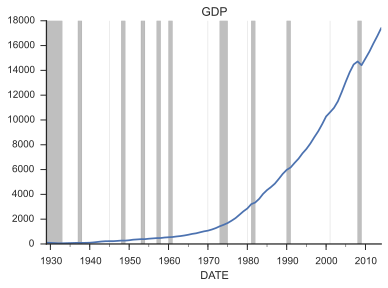

In [36]:
ax = gdp.plot(title='GDP')
add_rec_bars(ax)
sns.despine()

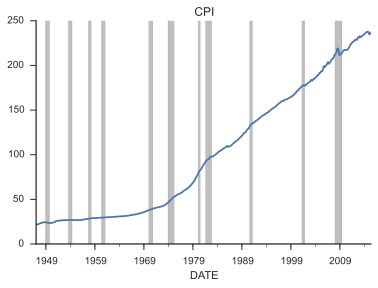

In [35]:
ax = cpi.plot(title='CPI')
add_rec_bars(ax)
sns.despine()

Let's put some of those operations to use.

First off, we'll convert the CPI base-2009 by dividing the Series by the average CPI in 2009.

In [41]:
# You *could* do this...
cpi.loc[pd.Timestamp('2009-01-01'):pd.Timestamp('2009-12-31')].mean()

214.56466666666668

In [42]:
# but timeseries (Series or DataFrames with a DatetimeIndex) are special 
base_09 = cpi.loc['2009'].mean()
base_09

214.56466666666668

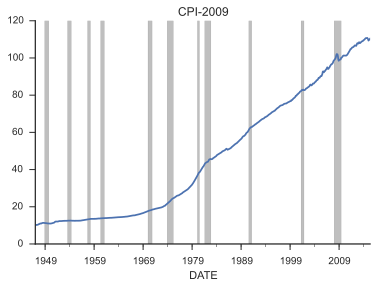

In [46]:
cpi09 = cpi / base_09 * 100
ax = cpi09.plot(title='CPI-2009')
add_rec_bars(ax=ax)
sns.despine();

# Alignment

We've been adding numbers and doing `ufuncs` on DataFrames and Series. Big deal, right?

Let's say we want real GDP (adjusted for inflation).

\begin{equation}
    rGDP_t = \frac{GDP_t}{CPI_t}
\end{equation}

Problem: our CPI is monthly but GDP is annual. Also the GDP series starts and stops before CPI. Pandas makes it somewhat easy to select the right months...

In [88]:
# this is boolean indexing, we'll see more later
cpi09[(cpi09.index.month == 1) & (cpi09.index.year <= 2014)]

DATE
1947-01-01     10.010968
1948-01-01     11.036300
1949-01-01     11.190100
1950-01-01     10.957070
1951-01-01     11.828602
                 ...    
2010-01-01    101.362449
2011-01-01    103.068228
2012-01-01    106.149350
2013-01-01    107.866781
2014-01-01    109.583746
Name: CPIAUCSL, dtype: float64

In [89]:
gdp[gdp.index.year >= 1947] / cpi09[(cpi09.index.month == 1) & (cpi09.index.year <= 2014)]

DATE
1947-01-01     24.962621
1948-01-01     24.899650
1949-01-01     24.378693
1950-01-01     27.397836
1951-01-01     29.361036
                 ...    
2010-01-01    147.632582
2011-01-01    150.559491
2012-01-01    152.268478
2013-01-01    155.451936
2014-01-01    158.955142
dtype: float64

... but that's unneccesary. The operations will automatically align for you.

In [48]:
rgdp = (gdp / cpi09)
rgdp.loc['1947']

DATE
1947-01-01    24.962621
1947-02-01          NaN
1947-03-01          NaN
1947-04-01          NaN
1947-05-01          NaN
                ...    
1947-08-01          NaN
1947-09-01          NaN
1947-10-01          NaN
1947-11-01          NaN
1947-12-01          NaN
dtype: float64

The `NaN`s are missing value indicators. `NaN`s can crop up for many reasons, but in this case it's because the labels didn't overlap perfectly.

Many pandas methods, e.g. aggregations like `sum` or `mean`, will ignore missing values

In [50]:
rgdp.mean()

84.66875957383985

Or you can explicitly drop them, which is what I'll do here.

In [51]:
rgdp.dropna()

DATE
1947-01-01     24.962621
1948-01-01     24.899650
1949-01-01     24.378693
1950-01-01     27.397836
1951-01-01     29.361036
                 ...    
2010-01-01    147.632582
2011-01-01    150.559491
2012-01-01    152.268478
2013-01-01    155.451936
2014-01-01    158.955142
dtype: float64

Pandas methods are non-mutating by default. This means that even though I called `.dropna()` above, `rgdp` still has missing values.

In [52]:
rgdp

DATE
1929-01-01   NaN
1930-01-01   NaN
1931-01-01   NaN
1932-01-01   NaN
1933-01-01   NaN
              ..
2015-01-01   NaN
2015-02-01   NaN
2015-03-01   NaN
2015-04-01   NaN
2015-05-01   NaN
dtype: float64

To capture the change, assign a name to the result. In this case, I just the same name `rgdp`.

In [54]:
rgdp = rgdp.dropna()
rgdp.head()

DATE
1947-01-01    24.962621
1948-01-01    24.899650
1949-01-01    24.378693
1950-01-01    27.397836
1951-01-01    29.361036
dtype: float64

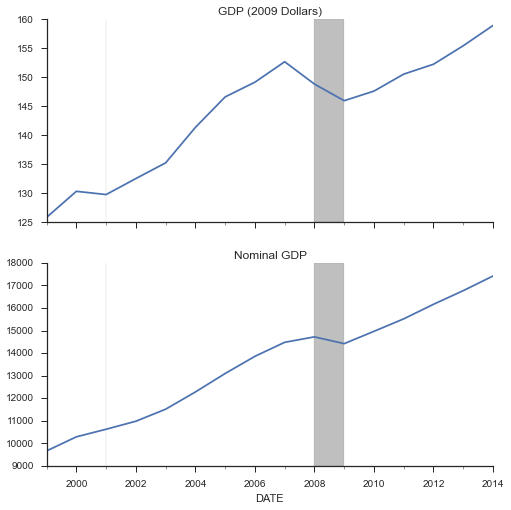

In [66]:
fig, axes = plt.subplots(figsize=(8, 8), nrows=2, sharex=True)

rgdp.loc['1999':].plot(ax=axes[0], title="GDP (2009 Dollars)")
add_rec_bars(axes[0])
axes[0].set_xlabel('')

gdp.loc['1999':].plot(ax=axes[1], title="Nominal GDP")
add_rec_bars(axes[1])

sns.despine()